In [1]:
import os
from PIL import Image
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D, InputLayer

# layers for preprocessing
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.data import AUTOTUNE
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from google.colab import drive
import pickle

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
save_path_train = '/content/drive/My Drive/saved_datasets/train_ds'
save_path_test = '/content/drive/My Drive/saved_datasets/test_ds'
train_ds = tf.data.experimental.load(save_path_train)
test_ds = tf.data.experimental.load(save_path_test)
test_ds

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


<_LoadDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Building Model

In [7]:
from tensorflow.keras.optimizers import Adam



model = Sequential()

model.add(InputLayer(input_shape=(256, 256, 3), batch_size=32))

model.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu', padding = 'same'))
model.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu', padding = 'same'))
model.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu', padding = 'same'))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu', padding = 'same'))
model.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu', padding = 'same'))
model.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))




model.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu', padding = 'same'))
model.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu', padding = 'same'))
model.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu', padding = 'same'))
model.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu', padding = 'same'))
model.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu', padding = 'same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(38, activation='softmax'))

learning_rate = 1e-4

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',  metrics=['accuracy'], )


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

vgg_model_notop = VGG16(input_shape = (256,256,3), include_top = False); # returns only conv part of network
vgg_model_notop.trainable = False
trainable_count = np.sum([K.count_params(w) for w in vgg_model_notop.trainable_weights])

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, BatchNormalization, InputLayer, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

BatchNorm_model = Sequential()

BatchNorm_model.add(InputLayer(input_shape=(256, 256, 3)))
BatchNorm_model.add(vgg_model_notop)

BatchNorm_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
BatchNorm_model.add(BatchNormalization())
BatchNorm_model.add(Activation('relu'))

BatchNorm_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
BatchNorm_model.add(BatchNormalization())
BatchNorm_model.add(Activation('relu'))

BatchNorm_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
BatchNorm_model.add(BatchNormalization())
BatchNorm_model.add(Activation('relu'))

BatchNorm_model.add(MaxPooling2D(pool_size=(2, 2)))


BatchNorm_model.add(GlobalAveragePooling2D())
BatchNorm_model.add(Flatten())
BatchNorm_model.add(Dense(64, activation='relu'))
BatchNorm_model.add(Dense(38, activation='softmax'))

learning_rate = 1e-3
optimizer = Adam(learning_rate=learning_rate)

BatchNorm_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()


In [ ]:
BatchNorm_model.summary()

# Adding Checkpoint and Fitting

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "/content/drive/My Drive/saved_models/model_epoch_{epoch:02d}_acc_{accuracy:.4f}.h5"

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [ ]:

history = model.fit(train_ds, epochs = 14, batch_size= 128, callbacks=[model_checkpoint_callback])

In [ ]:
bn_history = BatchNorm_model.fit(train_ds, epochs = 14, batch_size= 128, callbacks=[model_checkpoint_callback])

# Load in already trained model

In [ ]:

checkpoint_path = "/content/drive/MyDrive/saved_models/model_epoch_14_acc_0.9691.h5"

history = load_model(checkpoint_path)

In [ ]:
checkpoint_path_batch = "/content/drive/MyDrive/saved_models/BatchNorm_model_epoch_12_acc_0.9592.h5"

history_batch = load_model(checkpoint_path_batch)

# Evaluation

In [ ]:
model.evaluate(test_ds)

In [ ]:
BatchNorm_model.evaluate(test_ds)

# Confusion Matrices for Both Models

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_prob = history.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis = 1)
y_val = np.concatenate([y for x, y in test_ds], axis=0)
cfmat = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay.from_predictions(y_val, y_pred)

def create_extended_tab_colormap(base_cmap_name, N=100):
    """Create an extended colormap with N colors based on a given base colormap."""
    base_cmap = plt.get_cmap(base_cmap_name)
    colors = base_cmap(np.linspace(0, 1, 20))  # Get 20 base colors from the original cmap

    # Interpolate to create more colors
    extended_colors = np.vstack([np.linspace(colors[i], colors[i + 1], N // 20, endpoint=False) for i in range(len(colors) - 1)])

    # Ensure the last color is included
    extended_colors = np.vstack([extended_colors, colors[-1]])

    # Create a new colormap from the extended list of colors
    return ListedColormap(extended_colors, name=f'extended_{base_cmap_name}')

# Create the extended colormap
tab80 = create_extended_tab_colormap('tab20', 100)

# Test the colormap by plotting something with it



disp.plot(include_values=False, cmap=tab80)
plt.xticks(rotation=90)
plt.title('CNN Confusion Matrix')
plt.tight_layout()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, classification_report, log_loss, f1_score, ConfusionMatrixDisplay, roc_auc_score

ybatch_pred = history_batch.predict(test_ds)
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Step 1: Extract true labels from test_ds
true_labels_batch = []
for images, labels in test_ds:
    true_labels_batch.extend(labels.numpy())  # Adjust based on your dataset structure
true_labels_batch = np.array(true_labels)

# Step 2: Adjust predictions (assuming y_pred are probabilities and it's a multi-class classification)
ybatch_pred_labels = np.argmax(ybatch_pred, axis=1)  # Convert probabilities to predicted class labels

# Make sure true_labels and y_pred_labels are now aligned and have the same shape
# Step 3: Calculate metrics
batch_accuracy = accuracy_score(true_labels_batch, ybatch_pred_labels)
batch_precision = precision_score(true_labels_batch, ybatch_pred_labels, average='macro')  # Use 'micro' or 'weighted' based on your needs
batch_recall = recall_score(true_labels_batch, ybatch_pred_labels, average='macro')
batch_report = classification_report(true_labels_batch, ybatch_pred_labels)

print(f'Accuracy: {batch_accuracy}, Precision: {batch_precision}, Recall: {batch_recall}, Report: {batch_report}')



# Recall, Precision and F1 Graph

In [ ]:
import matplotlib.pyplot as plt

report_dict = classification_report(true_labels, y_pred_labels, output_dict=True)

classes = sorted([k for k in report_dict.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']])
precision = [report_dict[cls]['precision'] for cls in classes]
recall = [report_dict[cls]['recall'] for cls in classes]
f1_score = [report_dict[cls]['f1-score'] for cls in classes]
class_metrics = {}

for cls in report_dict.keys():
    if cls not in ['accuracy', 'macro avg', 'weighted avg']:
        precision = report_dict[cls]['precision']
        recall = report_dict[cls]['recall']
        f1 = report_dict[cls]['f1-score']
        average_score = (precision + recall + f1) / 3
        class_metrics[cls] = {'precision': precision, 'recall': recall, 'f1': f1, 'average': average_score}


sorted_classes = sorted(class_metrics, key=lambda x: class_metrics[x]['average'])


precision = [class_metrics[cls]['precision'] for cls in sorted_classes]
recall = [class_metrics[cls]['recall'] for cls in sorted_classes]
f1_score = [class_metrics[cls]['f1'] for cls in sorted_classes]


r1 = np.arange(len(sorted_classes))
r2 = [x + 0.25 for x in r1]
r3 = [x + 0.25 for x in r2]


plt.figure(figsize=(12, 8))
plt.bar(r1, precision, color='b', width=0.25, edgecolor='grey', label='Precision')
plt.bar(r2, recall, color='r', width=0.25, edgecolor='grey', label='Recall')
plt.bar(r3, f1_score, color='g', width=0.25, edgecolor='grey', label='F1-Score')


plt.xlabel('Class')
plt.xticks([r + 0.25 for r in range(len(sorted_classes))], sorted_classes, rotation=90)
plt.ylabel('Score')
plt.title('Classification Metrics per Class (Sorted by Average Score)')


plt.ylim(0.5, 1.01)
plt.legend()
plt.tight_layout()
plt.show()


# Exploring Errors (Class 7 and 10)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/54303 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/1.0.2.incomplete2XYRL8/plant_village-train.tfrecord*...:   0…

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


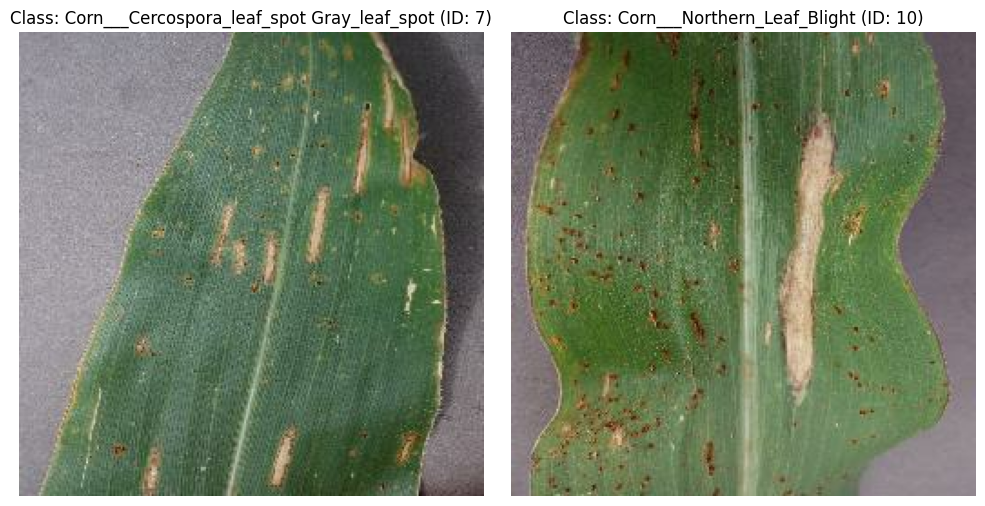

In [3]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


ds, ds_info = tfds.load('plant_village', split='train', with_info=True)


class_ids = [7, 10]


filtered_ds = ds.filter(lambda x: tf.reduce_any(tf.equal(x['label'], class_ids)))


fig, axes = plt.subplots(nrows=1, ncols=len(class_ids), figsize=(5 * len(class_ids), 5))
if len(class_ids) == 1:  # If there's only one class, put the axes in a list
    axes = [axes]

class_counts = {class_id: 0 for class_id in class_ids}

class_names = ds_info.features['label'].names

for example in filtered_ds.as_numpy_iterator():
    label = example['label']

    if class_counts[label] == 0:

        position = class_ids.index(label)

        axes[position].imshow(example['image'])

        class_name = class_names[label]
        axes[position].set_title(f'Class: {class_name} (ID: {label})')
        axes[position].axis('off')

        class_counts[label] += 1

    if all(value > 0 for value in class_counts.values()):
        break

plt.tight_layout()
plt.show()
